In this version, use more matrix implementation P0YP0 P1YP1 to hopefully reduce optimization time, get a working version of VQE for scipy, and something to compare and discuss with Anthony with. (When he uses P0YP0 P1YP1, how does he then later move it to qiskit)

In [1]:
%run SetUp.ipynb

from scipy.optimize import minimize

In [2]:
nQ = 6

## Define VQE form

In [138]:
# Layers of VQE
# "which is either proj0 or proj1"

def PYP(angle,nq,which,state):
    n_sets = int(nq/2)
    mat1 = sp.sparse.identity(2**nq)
    mat2 = sp.sparse.identity(2**nq)

    for mm in range(n_sets):
        bb,cc,dd = (2*mm+1)%nq,(2*mm+2)%nq,(2*mm+3)%nq
        state = sp.sparse.linalg.expm_multiply(-1j * angle * pad_op(bb,nq,which) @ pad_op(cc,nq,y) @ pad_op(dd,nq,which),state) #-1j * 
        
    #state = mat1 @ state
    
    for m in range(n_sets):
        aa,bb,cc = (2*m)%nq,(2*m+1)%nq,(2*m+2)%nq
        state =  sp.sparse.linalg.expm_multiply(-1j * angle * pad_op(aa,nq,which) @ pad_op(bb,nq,y) @ pad_op(cc,nq,which),state)
        
    #state = sp.sparse.linalg.expm_multiply(-1j * mat2, state)

    return state


In [139]:
PYP(5,12,proj1,fake_vac(12))

<4096x1 sparse array of type '<class 'numpy.complex128'>'
	with 1 stored elements in Compressed Sparse Column format>

In [140]:
def apply_vqe_form(angles,nq,state):
    it = iter(angles)
    #mat = sp.sparse.identity(2**nq)
    for i in range(len(angles)):
        if i % 2 == 0: # ugh
            proj = proj1
        else: proj = proj0
        angle = next(it)
        state = PYP(angle,nq,proj,state)
    return state

## Set up function to minimize and initial points

In [141]:

# Generate Fake Vacuum
# version that generates [[1,0,...]] and has dimension issues:  
#  fake_vac = ft.reduce(sp.sparse.kron, [[1,0]]* nq)

#fake_vac = sp.sparse.csr_array(np.ndarray.flatten(ft.reduce(sp.sparse.kron, [[1,0]]* nq).toarray()))

def fake_vac(nq):
    return sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[1.,0.]]* nq).toarray()).transpose()

In [142]:
# Generate a state from a set of angles
# Calculate full Hamiltonian expectation value for this state 
# Want to minimize this expectation value

num_params = 3

# Hf = sp.sparse.bsr_matrix(Hfull(nq,m,g).to_matrix())

Hf = sp.sparse.csr_matrix(np.real(Hfull(nQ,m,g).to_matrix()))

def H_exp(angles):
    
    state = apply_vqe_form(angles,nQ,fake_vac(nQ)) # turning fake vac into a function might increase runtime
    
    #val = np.reshape(np.asarray(state.conjugate()),-1) @ Hf @ np.reshape(np.asarray(state),-1)
    val = state.conj().T @ Hf @ state
    
    return np.real(val.toarray()[0][0])

In [143]:
# Test to see if H_exp gets results as expected

test_state = sp.sparse.csr_array(mathematica_result_6_SU2).transpose()
test_val = test_state.getH() @ Hf @ test_state
test_val.toarray()[0][0]

/var/folders/px/x0b827mx07s9_8yq2xxdt9qr0000gr/T/ipykernel_5256/1897183568.py:4: DeprecationWarning: `getH` is deprecated and will be removed in v1.13.0; use `X.conj().T` instead.
  test_val = test_state.getH() @ Hf @ test_state


-0.6909044667416253

In [144]:
initial_point = np.random.rand(num_params)
H_exp(initial_point)

/var/folders/px/x0b827mx07s9_8yq2xxdt9qr0000gr/T/ipykernel_5256/501145630.py:16: DeprecationWarning: `getH` is deprecated and will be removed in v1.13.0; use `X.conj().T` instead.
  val = state.getH() @ Hf @ state


10.125238172170691

In [145]:
H_exp([-0.08070716, -0.09582326, -0.14136288])

/var/folders/px/x0b827mx07s9_8yq2xxdt9qr0000gr/T/ipykernel_5256/501145630.py:16: DeprecationWarning: `getH` is deprecated and will be removed in v1.13.0; use `X.conj().T` instead.
  val = state.getH() @ Hf @ state


-0.5792994632083811

## Run VQE

#### nelder-mead

In [168]:
res = minimize(H_exp, initial_point, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

/var/folders/px/x0b827mx07s9_8yq2xxdt9qr0000gr/T/ipykernel_5256/501145630.py:16: DeprecationWarning: `getH` is deprecated and will be removed in v1.13.0; use `X.conj().T` instead.
  val = state.getH() @ Hf @ state


Optimization terminated successfully.
         Current function value: -0.690789
         Iterations: 137
         Function evaluations: 268


In [169]:
print(res.x)

[ 0.57540063 -0.15949662 -0.04035577]


#### powell

In [157]:
res2 = minimize(H_exp, initial_point, method='powell',
               options={'disp': True})

/var/folders/px/x0b827mx07s9_8yq2xxdt9qr0000gr/T/ipykernel_5256/501145630.py:16: DeprecationWarning: `getH` is deprecated and will be removed in v1.13.0; use `X.conj().T` instead.
  val = state.getH() @ Hf @ state


Optimization terminated successfully.
         Current function value: -0.638988
         Iterations: 2
         Function evaluations: 50


In [158]:
print(res2.x)

[ 0.44285798 -3.28519     2.65879392]


#### BFGS

In [159]:
res3 = minimize(H_exp,initial_point, method='BFGS', tol = 1e-8,
               options={'disp': True})

# tol = 1e-8,
# xatol = 1e-8,

/var/folders/px/x0b827mx07s9_8yq2xxdt9qr0000gr/T/ipykernel_5256/501145630.py:16: DeprecationWarning: `getH` is deprecated and will be removed in v1.13.0; use `X.conj().T` instead.
  val = state.getH() @ Hf @ state


Optimization terminated successfully.
         Current function value: -0.690789
         Iterations: 13
         Function evaluations: 160
         Gradient evaluations: 40


In [161]:
print(res3.x)

[ 0.44285798 -0.15949663 -0.04035574]


## Test

Agrees nicely with 6 qubits numerical results. Does not work great for 8 qubits but good for 12 qubits. Assuming 12 qubits is also divisable by 6,so the vqe_form are set up the same as 12, vs for 8 qubits there are some weird boundary stuff. 3 layers behave better than 1 layer for 12 qubits. 

#### Against mathematica result for 6 qubits

In [162]:
#[-0.08070716, -0.09582326, -0.14136288]
#[-0.56718282,  0.44043292, -0.19426729]
#[-0.26173984, -0.28023671,  0.22319269]
#[-0.56723781,  0.24395558]
# [ 0.57540063, -0.15949662, -0.04035577]
scipy_angles =[ 0.44285798, -0.15949663, -0.04035574]
scipy_results = np.reshape(apply_vqe_form(scipy_angles,nQ,fake_vac(nQ)).toarray(),-1)

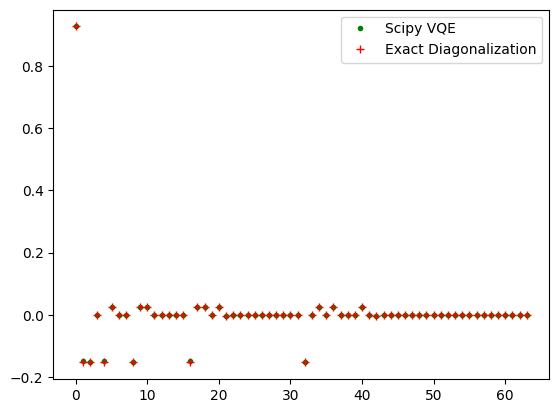

In [163]:
plt.plot(list(range(2**nQ)), scipy_results,'g.',label = 'Scipy VQE')
plt.plot(list(range(2**nQ)), mathematica_result_6_SU2,'r+',label = 'Exact Diagonalization')
plt.legend()

#### Angle aquired from 6 qubits on 8 qubits

In [170]:
ang = [ 0.57540063, -0.15949662, -0.04035577]
nQ_8 = 8

vacuum_8 = np.reshape(apply_vqe_form(ang,nQ_8,fake_vac(nQ_8)).toarray(),-1)

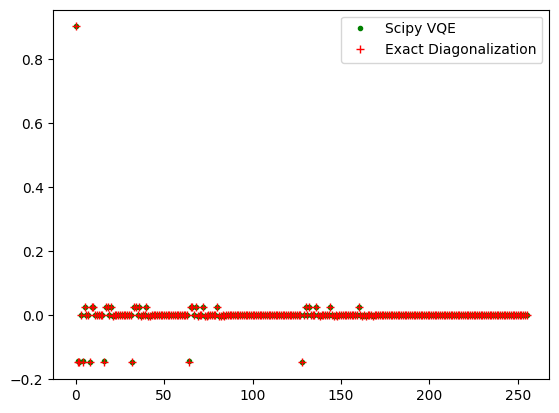

In [171]:
plt.plot(list(range(2**nQ_8)), vacuum_8,'g.',label = 'Scipy VQE')
plt.plot(list(range(2**nQ_8)), -np.array(mathematica_result_8_SU2),'r+',label = 'Exact Diagonalization')
plt.legend()

In [173]:
Hf_8 = sp.sparse.csr_matrix(np.real(Hfull(nQ_8,m,g).to_matrix()))
vacuum_8 = apply_vqe_form(ang,nQ_8,fake_vac(nQ_8))

In [174]:
(vacuum_8.getH() @ Hf_8 @ vacuum_8).toarray()

/var/folders/px/x0b827mx07s9_8yq2xxdt9qr0000gr/T/ipykernel_5256/1847113859.py:1: DeprecationWarning: `getH` is deprecated and will be removed in v1.13.0; use `X.conj().T` instead.
  (vacuum_8.getH() @ Hf_8 @ vacuum_8).toarray()


array([[-0.92105169+0.j]])

#### Angle aquired from 6 qubits on 12 qubits (1 parameter)

In [54]:
ang = [-0.3188006]
nQQ = 12

In [55]:
Hf_12 = sp.sparse.csr_matrix(np.real(Hfull(nQQ,m,g).to_matrix()))
vacuum_12 = vqe_form(ang,nQQ).dot(fake_vac(nQQ))

/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [56]:
(vacuum_12.getH() @ Hf_12 @ vacuum_12).toarray()

array([[-1.38126538+0.j]])

In [57]:
vacuum_12

<4096x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 466 stored elements in Compressed Sparse Row format>

/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


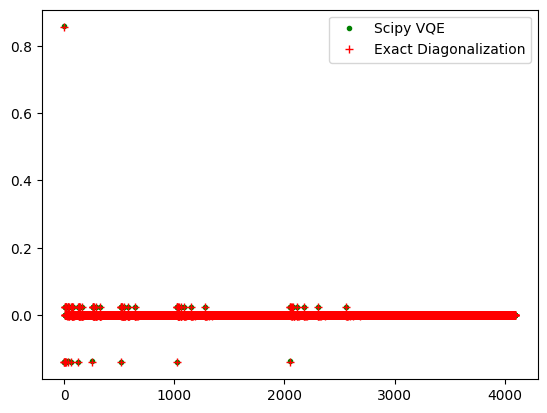

In [59]:
plt.plot(list(range(2**nQQ)), vacuum_12.toarray(),'g.',label = 'Scipy VQE')
plt.plot(list(range(2**nQQ)), np.array(mathematica_result_12_SU2),'r+',label = 'Exact Diagonalization')
plt.legend()

#### Angle aquired from 6 qubits on 12 qubits (3 parameters)

In [45]:
ang = [-0.08070716, -0.09582326, -0.14136288]
nQQ = 12

/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [46]:
Hf_12 = sp.sparse.csr_matrix(np.real(Hfull(nQQ,m,g).to_matrix()))
vacuum_12 = vqe_form(ang,nQQ).dot(fake_vac(nQQ))

In [47]:
(vacuum_12.getH() @ Hf_12 @ vacuum_12).toarray()

array([[-1.38172513+0.j]])

In [51]:
vacuum_12

array([ 8.57812810e-01+0.j, -1.39827376e-01+0.j, -1.40379982e-01+0.j, ...,
       -1.38354625e-11+0.j, -1.10320339e-11+0.j,  1.58480933e-12+0.j])

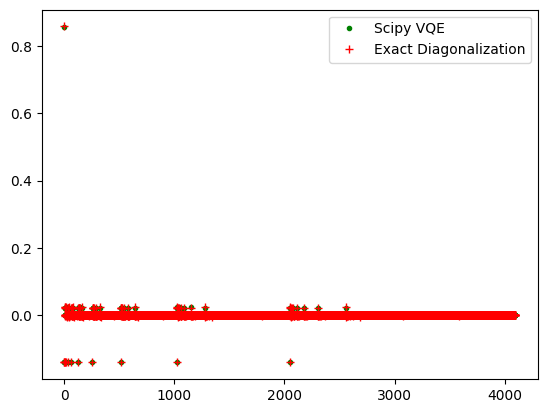

In [53]:
plt.plot(list(range(2**nQQ)), vacuum_12,'g.',label = 'Scipy VQE')
plt.plot(list(range(2**nQQ)), np.array(mathematica_result_12_SU2),'r+',label = 'Exact Diagonalization')
plt.legend()